In [1]:
# library imports
import os
import math
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

-1

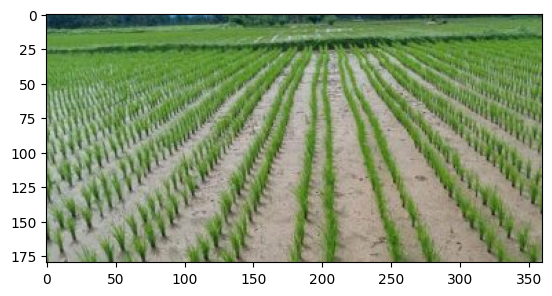

In [2]:
# sample image reading
img = cv.imread("./assets/images/sawah4.jpg")
lane_img = np.copy(img)
plt.imshow(img[...,::-1])
cv.waitKey(0)

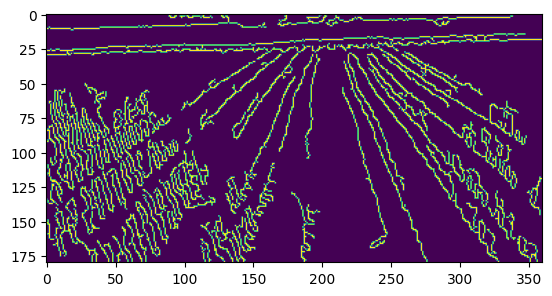

In [3]:
# Canny edge detection
def canny_edge(image):
    # rgb to grayscale and applying Gaussian blur to smoothen the image
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    blur = cv.GaussianBlur(gray, (5, 5), 0)
    canny = cv.Canny(blur, 50, 200)
    return canny
canny_img = canny_edge(lane_img)
plt.imshow(canny_img)

In [4]:
# ROI extraction
def region_of_interest(image):
    height = image.shape[0]
    polygons = np.array([[(140, height), (220, height), (200, 25)]])
    mask = np.zeros_like(image)
    cv.fillPoly(mask, polygons, 255)
    masked_img = cv.bitwise_and(image, mask)
    return masked_img

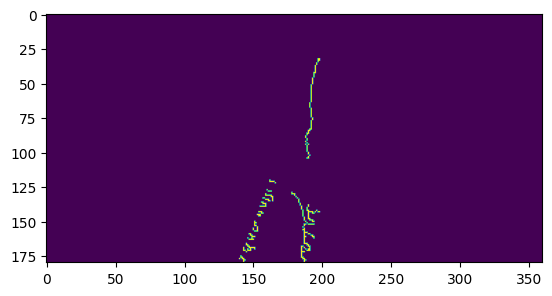

In [5]:
# Hough transform
cropped = region_of_interest(canny_img)
plt.imshow(cropped)
lines = cv.HoughLinesP(cropped, 2, np.pi/180, 10, np.array([]), minLineLength=40, maxLineGap=5)

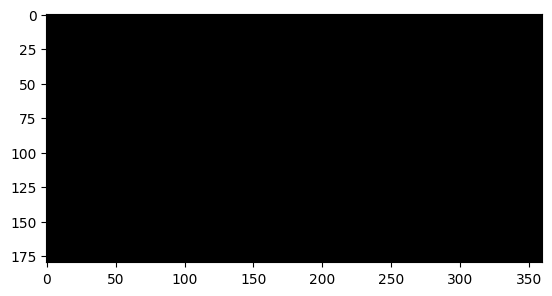

In [6]:
# Display the line
def display_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)
            cv.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 5)
    return line_image
lined = display_lines(lane_img, lines)    
plt.imshow(lined)

In [ ]:
# Display the line on the original image
result_img = cv.addWeighted(lane_img, 0.8, lined, 1, 1)
plt.imshow(result_img[...,::-1])

In [ ]:
# Optimize the lines
def make_coordinates(image, line_params):
    m, b = line_params
    y1 = image.shape[0]
    y2 = int(y1*(3/5))
    x1 = int((y1 - b)/m)
    x2 = int((y2 - b)/m)
    return np.array([x1, y1, x2, y2])

def average_slope_intercept(image, lines):
    left_fit = []
    right_fit = []
    for line in lines:
        x1, y1, x2, y2 =  line.reshape(4)
        params = np.polyfit((x1, x2), (y1, y2), 1)
        m = params[0]
        b = params[1]
        if m < 0:
            left_fit.append((m, b))
        else:
            right_fit.append((m, b))
    left_fit_avg = np.average(left_fit, axis=0)
    right_fit_avg = np.average(right_fit, axis=0)
    left_line = make_coordinates(image, left_fit_avg)
    right_line = make_coordinates(image, right_fit_avg)
    return np.array([left_line, right_line])

averaged = average_slope_intercept(lane_img, lines)

In [ ]:
opt_lined = display_lines(lane_img, averaged)
opt_result_img = cv.addWeighted(lane_img, 0.8, opt_lined, 1, 1)
plt.imshow(opt_result_img[..., ::-1])

In [ ]:
# Video test
cap = cv.VideoCapture("./assets/videos/road_vid.mp4")
while cap.isOpened():
    _, frame = cap.read()
    canny_vid = canny_edge(frame)
    cropped_vid = region_of_interest(canny_vid)
    lines_vid = cv.HoughLinesP(cropped_vid, 2, np.pi/180, 100, np.array([]), minLineLength=40, maxLineGap=5)
    averaged_vid = average_slope_intercept(frame, lines_vid)
    lined_vid = display_lines(frame, averaged_vid)
    result_vid = cv.addWeighted(frame, 0.8, lined_vid, 1, 1)
    cv.imshow("result", result_vid)
    if cv.waitKey(100) & 0xFF == ord('q'):
        break
cap.release()
cv.destroyAllWindows()